# Assignment 2 by: Christian Nieves (s4005338)


# Data Sampling

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

In [4]:
# Read in the csv file
df = pd.read_csv('A2data.csv')

In [ ]:
# Convert all missing values with the average for that column 
# Next, round each value to the type of column in the csv file (e.g. quality is integer but alcohol is 1 decimal point)

# Ensure volatile_acidity, pH and sulphates are 2 decimal points
df['volatile_acidity'] = df['volatile_acidity'].fillna(df['volatile_acidity'].mean()).round(2)
df['pH'] = df['pH'].fillna(df['pH'].mean()).round(2)
df['sulphates'] = df['sulphates'].fillna(df['sulphates'].mean()).round(2)

# Ensure free_sulfur_dioxide, total_sulfur_dioxide and quality is rounded to an integer
df['free_sulfur_dioxide'] = df['free_sulfur_dioxide'].fillna(df['free_sulfur_dioxide'].mean()).round()
df['total_sulfur_dioxide'] = df['total_sulfur_dioxide'].fillna(df['total_sulfur_dioxide'].mean()).round()
df['quality'] = df['quality'].fillna(df['quality'].mean()).round()

# Ensure alcohol is rounded to one decimal point
df['alcohol'] = df['alcohol'].fillna(df['alcohol'].mean()).round(1)


In [ ]:
# Create samples for each task
# Generate CSV files

# Task1: 200 instances
df_sampleOne = df.sample(n=200)

# Task2: 1000 instances
df_sampleTwo = df.sample(n=1000)

# Task3: 600 instances
df_sampleThree = df.sample(n=600)

# Save each sample to a new csv file
# df_sampleOne.to_csv('s4005338-A2SampleOne.csv', index=False)
# df_sampleTwo.to_csv('s4005338-A2SampleTwo.csv', index=False)
# df_sampleThree.to_csv('s4005338-A2SampleThree.csv', index=False)

# Task 1: Regression


In [8]:
# Load sample one
df1 = pd.read_csv('s4005338-A2SampleOne.csv')

In [ ]:
# Get X and Y values (let X be volatile acidity against Y which is pH)
X = df1['volatile_acidity'].values.reshape(-1, 1)
Y = df1['pH'].values

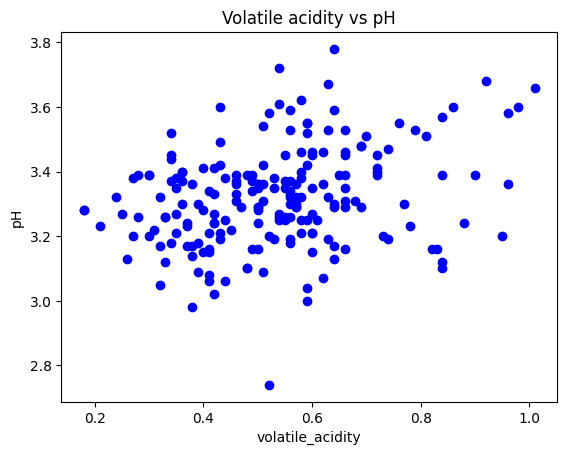

In [ ]:
# Visualize volatile_acidity (X) against pH (Y) on a scatter plot
plt.scatter(X, Y, color='blue')
plt.xlabel('volatile_acidity')
plt.ylabel('pH')
plt.title('Volatile acidity vs pH')
plt.show()

In [11]:
# Train the linear regression model
model = LinearRegression()
model.fit(X, Y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
# Get predictions, coefficient and intercept
y_pred = model.predict(X)

# Print out coefficinet and intercept
print(f"Coefficient: {model.coef_}")
print(f"Intercept: {model.intercept_}")


Coefficient: [0.27399597]
Intercept: 3.1734587534467837


In [13]:
# Evaluate the model
mse = mean_squared_error(Y, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.14739964883267614


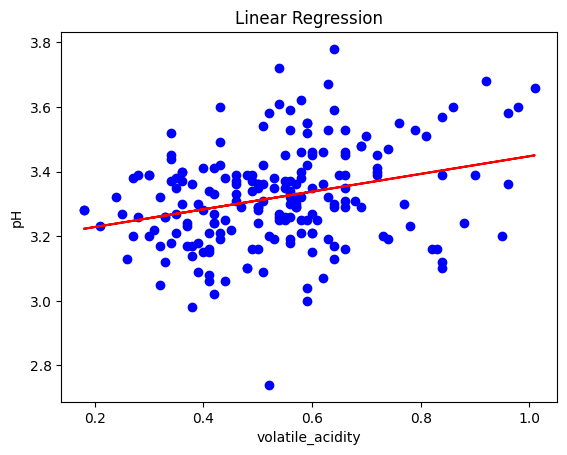

In [ ]:
# Plot the regression model on top of the scatter plot
plt.scatter(X, Y, color='blue')
plt.plot(X, y_pred, color='red')

plt.xlabel('volatile_acidity')
plt.ylabel('pH')
plt.title('Linear Regression')
plt.show()

# Task 2: Classification

## Processing Data

In [ ]:
# Loading the sample and spliting training and testing data

#Load sample1
df2 = pd.read_csv('s4005338-A2SampleTwo.csv')

# Get columns/features (X) and target (y)
# Let X be all features except quality
X = df2.drop('quality', axis=1) 

#Let Y be the target, which is quality
y = df2['quality']

# Split the data into training and testing sets (20% training set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [17]:
# Convert data into scaled values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## kNN

In [ ]:
# Find the best K value for the current randomised data set
# Check k values in the range of 1 to 31
kNNrange = range(1, 31)

# Store all the scores in a list
scores = []

# k-fold cross-validation
for i in range(1,31):

    clf = KNeighborsClassifier(n_neighbors=i)
    score = cross_val_score(clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
    scores.append(score.mean())

# Best K
kValue = kNNrange[scores.index(max(scores))]
print(f"Optimal K value is {kValue}")

Optimal K value is 23


In [ ]:
# Train the model using the optimal k value
clf = KNeighborsClassifier(n_neighbors=kValue)
fit = clf.fit(X_train_scaled, y_train)
y_pred_knn = fit.predict(X_test_scaled)

# Show the confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)
print(cm)

[[ 0  0  4  0  0  0]
 [ 0  0  2  0  0  0]
 [ 0  0 63 23  0  0]
 [ 0  0 24 48  7  0]
 [ 0  0  2 18  6  0]
 [ 0  0  0  1  2  0]]


In [20]:
# Show the classification report
print(classification_report(y_test, y_pred_knn, zero_division=0))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         4
         4.0       0.00      0.00      0.00         2
         5.0       0.66      0.73      0.70        86
         6.0       0.53      0.61      0.57        79
         7.0       0.40      0.23      0.29        26
         8.0       0.00      0.00      0.00         3

    accuracy                           0.58       200
   macro avg       0.27      0.26      0.26       200
weighted avg       0.55      0.58      0.56       200



## Modified kNN 

In [21]:
# Modify the kNN using weights and a custom distance metric

# Custom weighted Minkowski distance function
def weightedMinKowski(x, y, p=2):

    # Weights scale based on column 
    # weights = np.array([2.0, 0.5, 0.5, 2.0, 1.5, 2.0])
    # weights = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    weights = np.array([2.5, 1.0, 1.0, 2.0, 0.5, 2.0])

    # Normal Minowski distance * weights
    diff = weights * (np.abs(x - y) ** p)
    return np.sum(diff) ** (1 / p)


In [22]:
# Train the model using weights = distance and the custom metric
clf = KNeighborsClassifier(n_neighbors=kValue, weights='distance', metric=weightedMinKowski)
fit = clf.fit(X_train_scaled, y_train)
y_pred_m_knn = fit.predict(X_test_scaled)

# Show the confusion matrix
cm = confusion_matrix(y_test, y_pred_m_knn)
print(cm)

[[ 0  0  4  0  0  0]
 [ 0  0  2  0  0  0]
 [ 0  0 67 19  0  0]
 [ 0  2 20 50  7  0]
 [ 0  0  2 10 14  0]
 [ 0  0  0  1  2  0]]


In [23]:
# Show the classification report
print(classification_report(y_test, y_pred_m_knn, zero_division=0))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         4
         4.0       0.00      0.00      0.00         2
         5.0       0.71      0.78      0.74        86
         6.0       0.62      0.63      0.63        79
         7.0       0.61      0.54      0.57        26
         8.0       0.00      0.00      0.00         3

    accuracy                           0.66       200
   macro avg       0.32      0.33      0.32       200
weighted avg       0.63      0.66      0.64       200



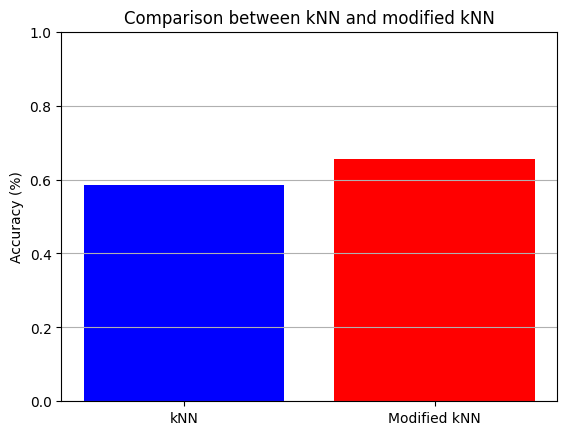

In [24]:
# Show the difference in accuracies between kNN and modified kNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_modified_knn = accuracy_score(y_test, y_pred_m_knn)

models = ['kNN', 'Modified kNN']
accuracies = [accuracy_knn, accuracy_modified_knn]

plt.bar(models, accuracies, color=['blue', 'red'])
plt.title('Comparison between kNN and modified kNN')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()


## Decision Tree & comparison

In [25]:
# Find the best parameters for the decision tree
model_tree = None
accuracy_tree = 0
max_depth_tree = 0
criterion_tree = ''

# Loop through different criterions and depth
for criterion in ['gini', 'entropy']:
    for depth in range(1, 20):

        # Train the model
        clf = DecisionTreeClassifier(max_depth=depth, criterion=criterion)
        fit = clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        # Get accuracy for current iteration
        current_accuracy = accuracy_score(y_test, y_pred)
        
        # Store the highest accuracy and the respective model
        if current_accuracy > accuracy_tree:
            accuracy_tree = current_accuracy
            model_tree = clf
            max_depth_tree = depth
            criterion_tree = criterion

# Best parameters
print(f"Maximum depth: {max_depth_tree}")
print(f"Criterion: {criterion_tree}")

# Accuracy for the best model
print(f"Accuracy: {accuracy_tree}")

Maximum depth: 19
Criterion: gini
Accuracy: 0.6


In [26]:
# Predict and evaluate the decision tree
y_pred_tree = model_tree.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)

# Show the confusion matrix
print(confusion_matrix(y_test, y_pred_tree))

# Show the classification report
print(classification_report(y_test, y_pred_tree, zero_division=0))

[[ 0  1  2  1  0  0]
 [ 0  0  1  1  0  0]
 [ 1  1 55 28  1  0]
 [ 1  7 12 49  9  1]
 [ 0  0  1  8 16  1]
 [ 0  0  1  0  2  0]]
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         4
         4.0       0.00      0.00      0.00         2
         5.0       0.76      0.64      0.70        86
         6.0       0.56      0.62      0.59        79
         7.0       0.57      0.62      0.59        26
         8.0       0.00      0.00      0.00         3

    accuracy                           0.60       200
   macro avg       0.32      0.31      0.31       200
weighted avg       0.63      0.60      0.61       200



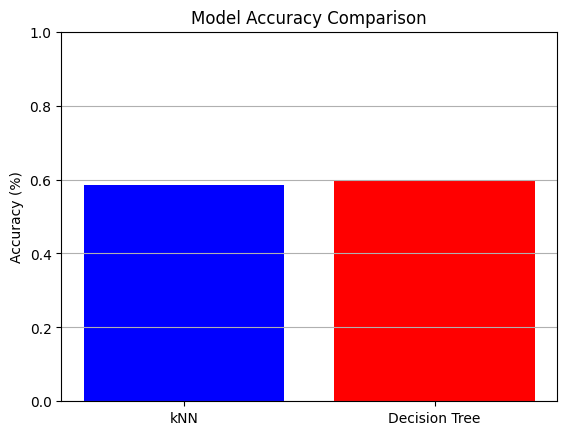

In [27]:
# Compare decision tree and unmodified kNN
# Get the accuracy of kNN and tree
accuracy_knn = accuracy_score(y_test, y_pred_knn)
models = ['kNN', 'Decision Tree']
accuracies = [accuracy_knn, accuracy_tree]

# Plot the difference
plt.bar(models, accuracies, color=['blue', 'red'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

# Task 3: Clustering

In [28]:
# Load sample Three
df3 = pd.read_csv('s4005338-A2SampleThree.csv')

# Get columns/features (X) and target (y)
X = df3.drop('quality', axis=1) 
y = df3['quality']

In [29]:
# Scale data
# Create a new dataframe using the scaled values of X
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns) 


## k-Means 

In [30]:
# Find optimal K values
# Store every value for elbow and silhouette for each run of the model
elbow_values = []
silhouette_values = []
k_range = range(2, 11)

for k in k_range:
    # Train the model
    model = KMeans(n_clusters=k, random_state=14)
    fit = model.fit(X_scaled)
    
    # Get the elbow value
    elbow_values.append(model.inertia_)
    
    # Get the silhouette score
    score = silhouette_score(X_scaled, model.labels_)
    silhouette_values.append(score)


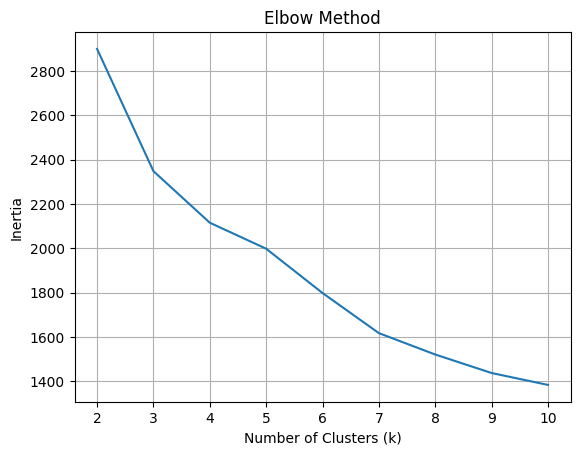

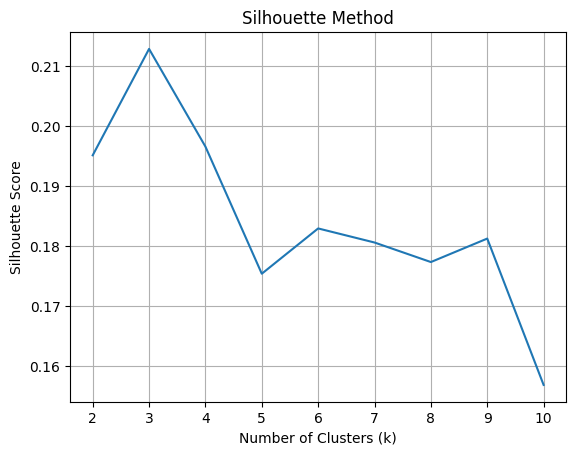

Optimal k value for silhouette: 3


In [31]:
# Plot graphs and show the optimal k value
# Elbow/Inertia
plt.plot(k_range, elbow_values)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Silhouette
plt.plot(k_range, silhouette_values)
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Calculate and show the optimal silhouette score
optimal_silhouette = k_range[np.argmax(silhouette_values)]
print(f"Optimal k value for silhouette: {optimal_silhouette}")


In [32]:
# Check the output of the model that uses the optimal silhouette value
model = KMeans(n_clusters=optimal_silhouette, random_state=14)
fit = model.fit(X_scaled)
X_scaled["cluster"] = fit.predict(X_scaled)
X_scaled["target"] = y
X_scaled["c"] = "count"

# Print result
clustering_result = X_scaled[["cluster", "target", "c"]].groupby(["cluster", "target"]).agg("count")
print(clustering_result)

                  c
cluster target     
0       4.0       2
        5.0      45
        6.0      89
        7.0      63
        8.0       4
1       4.0       3
        5.0     102
        6.0      55
        7.0       7
        8.0       1
2       3.0       3
        4.0      12
        5.0     101
        6.0      99
        7.0      13
        8.0       1


## DBSCAN & comparison 

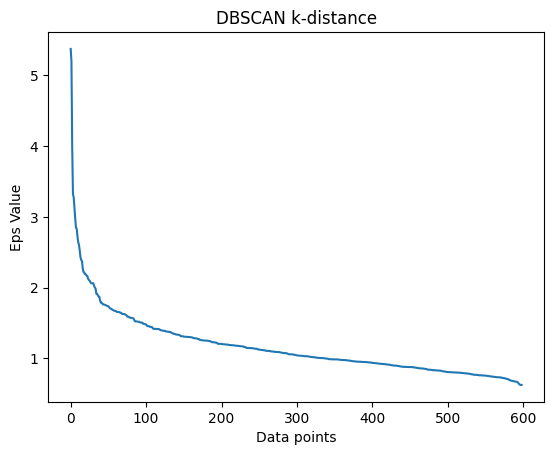

In [33]:
# Create a new dataframe for the scaled values of X
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns) 

# Train neighbours
nbrs = NearestNeighbors().fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled, 20)
kDis = distances[:, 6] 
kDis.sort()
kDis = kDis[list(range(len(kDis) - 1, 0, -1))]

# Show graph
plt.plot(kDis)
plt.xlabel("Data points")
plt.ylabel(f"Eps Value")
plt.title(f"DBSCAN k-distance")
plt.show()

In [34]:
# Create a new dataframe for the scaled values of X
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns) 

# Train the model using the "eps" value from the graph
# min_samples is the number of features + 1 
model = DBSCAN(eps=1.9, min_samples=7)
results = model.fit(X_scaled)

X_scaled['cluster'] = results.labels_
X_scaled['target'] = y 
X_scaled['c'] = 'count'

# Print the result
classification_result = X_scaled[['cluster', 'target', 'c']].groupby(['cluster', 'target']).agg('count')
print(classification_result)


                  c
cluster target     
-1      4.0       3
        5.0       9
        6.0       4
        8.0       2
 0      3.0       3
        4.0      14
        5.0     239
        6.0     239
        7.0      83
        8.0       4
